# Process the REBASE emboss files, and the UR_rnd_ files in Data_stats

Processing UR results of random viruses.
LOCAL UPDATE FOR m=5 FOR RANDOM VIRUS p-values !!!
LOCAL UPDATE FOR m=5 FOR RANDOM VIRUS p-values !!!


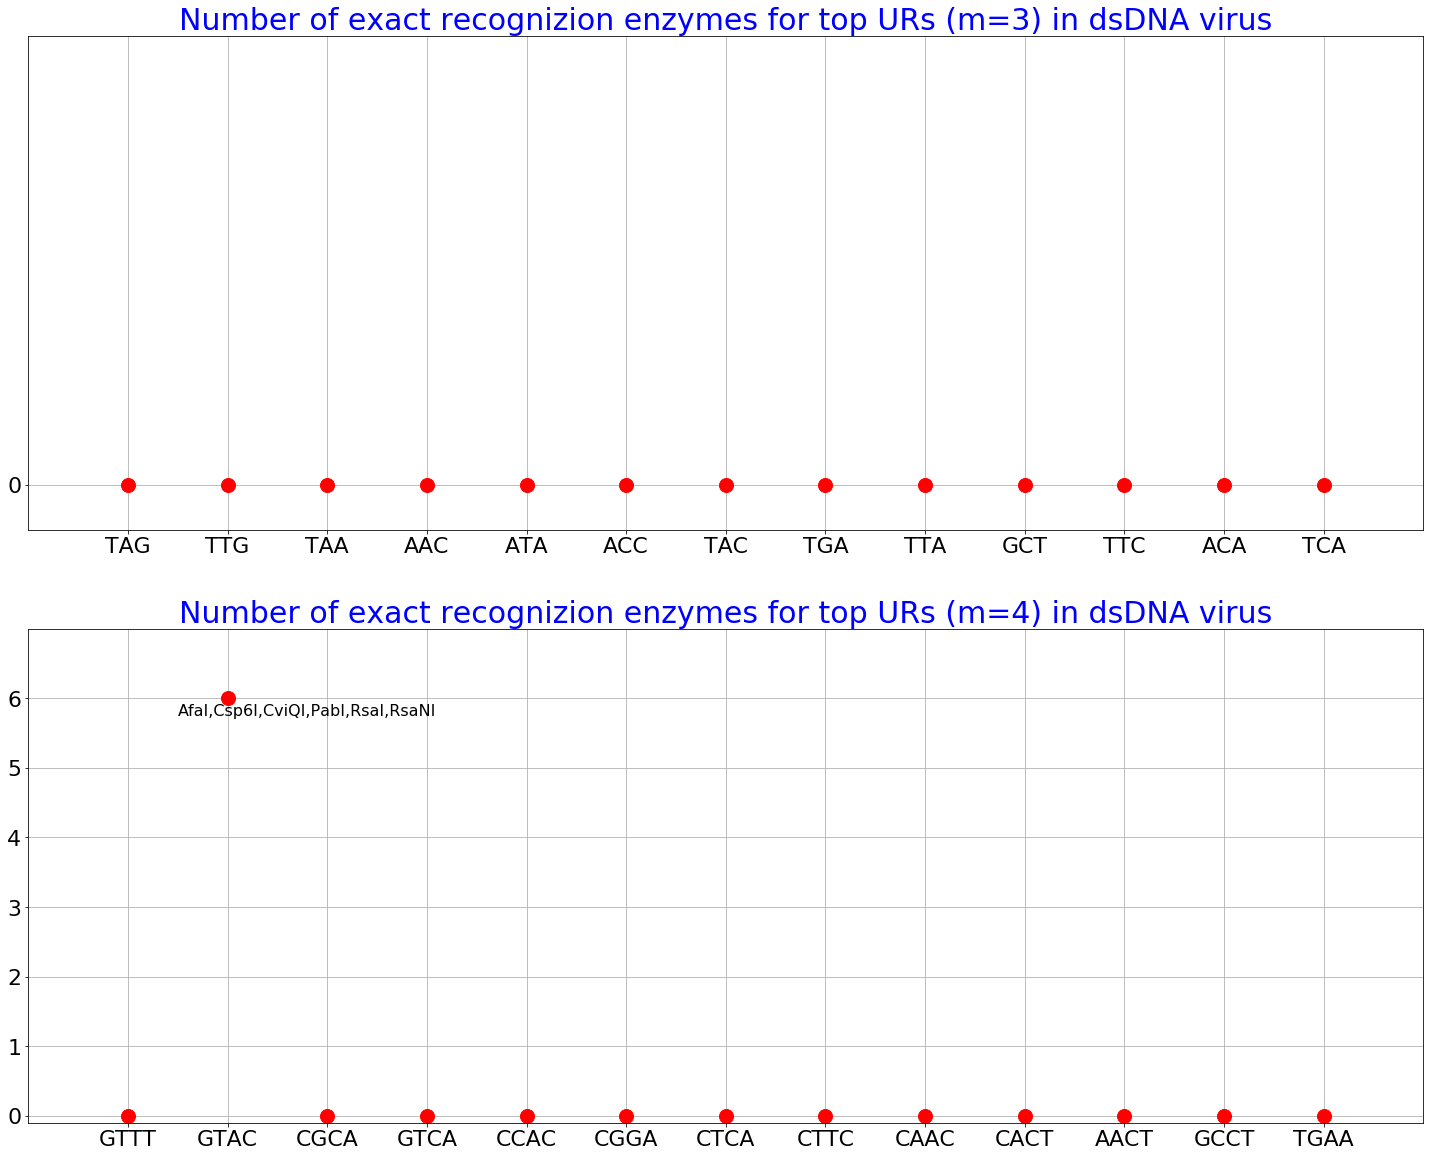

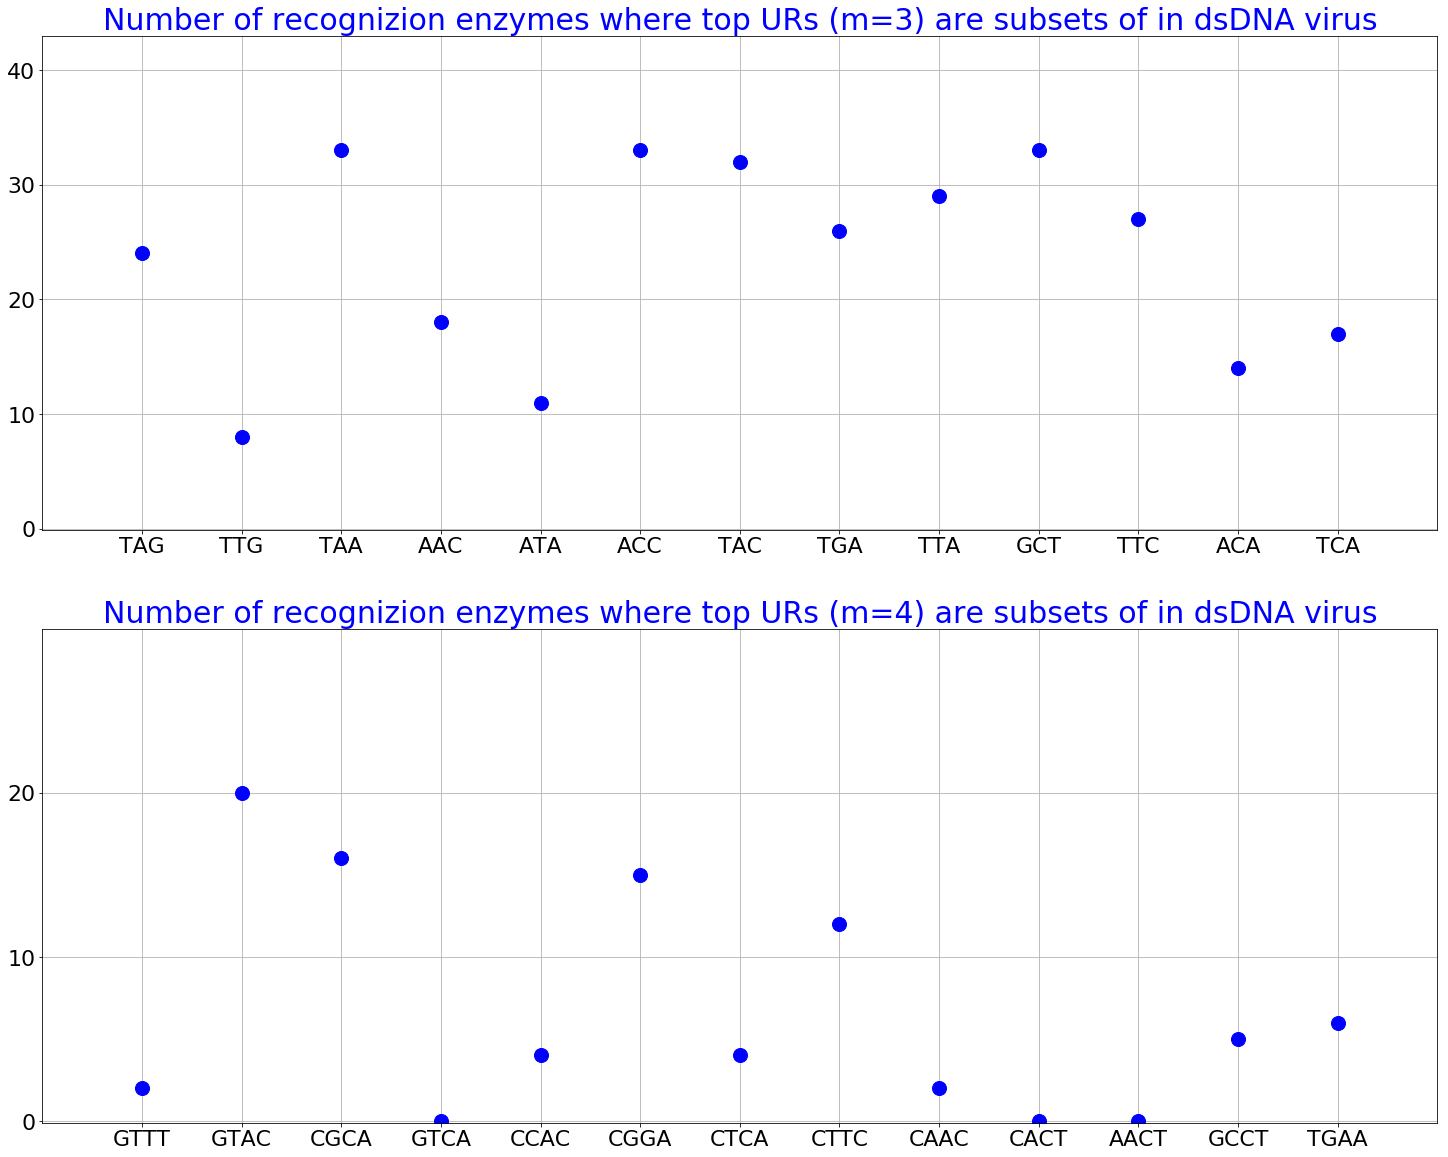

In [19]:
import UR_host_funcs as urfuncs
import pandas as pd
import os, sys
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt
from functools import reduce
import translation as tran  # my translation functions
import numpy as np
import random

def collect_emboss_epat(df, k_indx=1, v_indx=0):
    '''Given a dataframe containing the emboss information (can be a subset), the function
    returns a dictionary where the key is a recognition site and the 
    value is the corresponding enzyme names (could be more than one)'''
    epat_dict = defaultdict(list)
    for i in range(len(df.index)): epat_dict[df.iloc[i][k_indx].upper()].append(df.iloc[i][v_indx])
    return epat_dict

def calc_superset_epat(proc_nt, epat_dict):
    '''Given a set of sequences (proc_nt) and the recognition site dictionary
    (returnet from collect_emboss_epat()), the function returns all the enzymes 
    names and binding site that proc_nt is a superset of'''
    # number of enzymes each UR is a SUBSET of
    sb_num_enzyme = [0 for i in range(len(proc_nt))]
    sb_name_enzyme = ['' for i in range(len(proc_nt))]
    for i, s in enumerate(proc_nt):
        kys = [k for k in epat_dict.keys() if s in k]
        if kys:
            sb_num_enzyme[i] = reduce(lambda x, y: x+y, [len(epat_dict[k]) for k in kys])
            sb_name_enzyme[i] = [epat_dict[k] for k in kys]  # the enzyme names
    return sb_num_enzyme, sb_name_enzyme

def calc_rand_superset(seqs, rand_seq_len, num_rands=1000):
    '''Computes the average number of random sequences that are subset of input sequences'''
    rseq = [tran.gen_random_bp_seq(rand_seq_len, True) for i in range(num_rands)]
    return len([j for i in rseq for j in seqs if i in j])/float(num_rands)

def calc_rand_epat_superset(epat_dict, rand_seq_len, num_rands=1000):
    '''Computes the average number of restriction enzymes that random sequences
    are subset of their binding sites'''
    rseq = [tran.gen_random_bp_seq(rand_seq_len, True) for i in range(num_rands)]
    # each key can have several enzymes associated with it, thus we divide by num_rands
    # and not average the list
    return np.sum([len(epat_dict[j]) for i in rseq for j in epat_dict.keys() if i in j])/float(num_rands)     

def calc_rand_epat_match(epat_dict, rand_seq_len, num_rands=1000):
    '''Computes the average number of restriction enzymes that random sequences
    are equals their binding sites'''
    rseq = [tran.gen_random_bp_seq(rand_seq_len, True) for i in range(num_rands)]
    # each key can have several enzymes associated with it, thus we divide by num_rands
    # and not average the list
    return np.sum([len(epat_dict[j]) for i in rseq for j in epat_dict.keys() if i==j])/float(num_rands)     

def calc_pvalue_epat_superset(wt_num, epat_dict, rand_seq_len, num_rands=1000):
    '''This function returns the p-value of each wt_num[i] for the case 
    of superset match.'''
    l = len(wt_num)
    wt = np.array(wt_num)
    pval = np.zeros(l)
    for i in range(num_rands):
        rseq = tran.gen_random_bp_seq(rand_seq_len, True) # random sequence
        rand = np.sum([len(epat_dict[k]) for k in epat_dict.keys() if rseq in k])*np.ones(l)
        pval += (rand>=wt).astype(int)
    return pval/num_rands

def calc_pvalue_epat_match(wt_num, epat_dict, rand_seq_len, num_rands=1000):
    '''This function returns the p-value of each wt_num[i] for the case
    of exact match.'''
    l = len(wt_num)
    wt = np.array(wt_num)
    pval = np.zeros(l)
    for i in range(num_rands):
        rseq = tran.gen_random_bp_seq(rand_seq_len, True) # random sequence
        rand = np.sum([len(epat_dict[k]) for k in epat_dict.keys() if rseq==k])*np.ones(l)
        pval += (rand>=wt).astype(int)
    return pval/num_rands

def calc_pvalue_randin_epat_match(wt_num, epat_dict, rand_seqs, num_rands=1000):
    '''This function uses the input rand_seqs list of random sequences and randomly
    selects sequences from it to compute the p-value'''
    l = len(wt_num)
    rl = len(rand_seqs)
    wt = np.array(wt_num)
    pval = np.zeros(l)
    for i in range(num_rands):
        rseq = rand_seqs[random.randint(0,rl-1)] # random sequence
        rand = np.sum([len(epat_dict[k]) for k in epat_dict.keys() if rseq==k])*np.ones(l)
        pval += (rand>=wt).astype(int)
    return pval/num_rands

def calc_pvalue_randin_epat_superset(wt_num, epat_dict, rand_seqs, num_rands=1000):
    '''This function uses the input rand_seqs list of random sequences and randomly
    selects sequences from it to compute the p-value'''
    l = len(wt_num)
    rl = len(rand_seqs)
    wt = np.array(wt_num)
    pval = np.zeros(l)
    for i in range(num_rands):
        rseq = rand_seqs[random.randint(0,rl-1)] # random sequence
        rand = np.sum([len(epat_dict[k]) for k in epat_dict.keys() if rseq in k])*np.ones(l)
        pval += (rand>=wt).astype(int)
    return pval/num_rands


# ==========================================================================================================

''' 
Read the emboss file downloaded from the REBASE site. 
See http://biopython.org/DIST/docs/cookbook/Restriction.html for general information,
and specifically the section Updating the enzymes from REBASE. Here, I only downloaded
the emboss files using Cyberduck and then I process them below.
'''
vfile_type = 'dsDNA'
top_num = 13  # top URs in the xlsx file
proc_type = 'neql' # URs to proces. Allowd values here are the keys of the return parameter from cluster_NTs function
dtype_rnd = {'signf_sorted_dsdna':str, 'tot_num_dsdna_Fall_sort':int} # columns type of xlsx file
dtype_Randvir_rnd = {'repeated_URs':str} # columns type of the URs of random viruses
'''This script can run the analysis of the WT viruses results (taken from 
Data_stats/UR_rnd_..,) or from the UR results of RANDOM viruses (taken from
Data_stats/UR_RandVirus_..,). The results for the random viruses were computed by the
Matlab function analyze_rand_vur_viruses.m. Set the following to True to use the
WT results, or to False to use the random results. NOTE that for the random case, results
exist only for m=3 and m=4. Also, make sure to set base_save_file accordinely.
'''
use_WT_results = True
mlens = [3, 4, 5] 
#mlens = [3, 4] 
emboss_file = './../Binding_sites/REBASE/emboss_e.811'
emboss_skip_row_num = 42 # number of rows to skip (from beginning)
num_rand = 5000
base_save_file = '' #'rebase_Randvur_'+vfile_type #'' #'rebase_vur_'+vfile_type # code appends '.png' to save the figure
# ====================================================================================================
if use_WT_results:
    print('Processing WT UR results.')
    base_path = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_rnd_'
    base_rnd_path = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_RandVirus_rep_'
    # xlsx with URs of random viruses appearing with multiplicity
else:
    print('Processing UR results of random viruses.')
    base_path = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_RandVirus_'
    base_rnd_path = False

mmlens = ['m'+str(m) for m in mlens]

# the emboss column names
emb_cols = ['name', 'pattern', 'len', 'ncuts', 'blunt', 'c1', 'c2', 'c3', 'c4' ]
# read the emboss file
df = pd.read_csv(emboss_file,sep='\s+',header=None, skiprows=emboss_skip_row_num, names=emb_cols)
res_len = df.loc[:, 'len']  # a Series with the length of each restriction enzyme (RESZ)

fig, axs = plt.subplots(len(mlens), 1, figsize=(25, 10*len(mlens)), squeeze=False)  # for the exact plot
fig1, axs1 = plt.subplots(len(mlens), 1, figsize=(25, 10*len(mlens)), squeeze=False) # for the subset plot
for j, m in enumerate(mlens):
    print('LOCAL UPDATE FOR m=5 FOR RANDOM VIRUS p-values !!!')
    if m==5: base_rnd_path = False
    
    # load the virus URs
    xlsx_file = base_path+mmlens[j]+'_'+vfile_type+'.xlsx'
    df_vrnd = pd.read_excel(xlsx_file, header=0, dtype=dtype_rnd)
    cur_vurs = set(df_vrnd.iloc[:top_num, 0].values)  # get top URs
    clst_hurs = urfuncs.cluster_NTs(cur_vurs, m) # cluster them
    # CHOOSE here what is proc_nt (the URs to compare for restriction sites)
    proc_nt = clst_hurs[proc_type] 
    #print(m, proc_nt, sep=': ')

    res = df[:][res_len>=m]  # subset with site length >= m
    res_dict = collect_emboss_epat(res)
    #pprint(res_dict)
    
    # check if URs are restriction sites (exact match)
    flag = [s for s in proc_nt if s in res_dict.keys()]
    # number of enzymes each UR sequence is exactly recognized by
    num_enzyme = [len(res_dict[s]) if s in flag else 0 for s in proc_nt]
    name_enzyme = [','.join(res_dict[s]) if s in flag else '' for s in proc_nt]
    
    # number of enzymes each UR is a SUBSET of
    sb_num_enzyme, sb_name_enzyme = calc_superset_epat(proc_nt, res_dict)
    #print(proc_nt, sb_num_enzyme, sep='\n')

    # load URs of random viruses
    if base_rnd_path: 
        xlsx_rnd_file = base_rnd_path+mmlens[j]+'_'+vfile_type+'.xlsx'
        df_Rvrnd = pd.read_excel(xlsx_rnd_file, header=0, dtype=dtype_Randvir_rnd)
        cur_Rvurs = df_Rvrnd.iloc[:, 0].values
        pvl_match = calc_pvalue_randin_epat_match(num_enzyme, res_dict, cur_Rvurs, num_rand)
        print(num_enzyme, pval_match, sep='\n')
    
    #pvl_match = calc_pvalue_epat_superset(num_enzyme, res_dict, m, num_rand)
    #print(num_enzyme, pvl_match, sep='\n')
    
    axs[j,0].plot(num_enzyme, 'ro', markersize=14)
    axs[j,0].set_xticks(range(len(proc_nt)))
    axs[j,0].set_xticklabels(proc_nt, fontsize=22)
    axs[j,0].set_yticks(range(max(num_enzyme)+1))
    axs[j,0].set_yticklabels(range(max(num_enzyme)+1), fontsize=22)
    for i, txt in enumerate(name_enzyme):
        axs[j,0].annotate(txt, (i, num_enzyme[i]), xytext=(i-.5, num_enzyme[i]+((-1)**i*0.25)), fontsize=16)
    if base_rnd_path:
        for i in range(len(proc_nt)):
            axs[j,0].annotate(str(pvl_match[i]), (i, num_enzyme[i]), xytext=(i+.01, num_enzyme[i]-0.6), fontsize=16)
    axs[j,0].grid(b=True, which='major')
    axs[j,0].axis([-1, len(num_enzyme), -.1, max(num_enzyme)+1])
    axs[j, 0].set_title('Number of exact recognizion enzymes for top URs (m='+str(m)+') in '+vfile_type+' virus', \
                        fontsize=30, color='blue')
    
    # mean number of enzymes that are superset in random
    sb_num_rand = [calc_rand_epat_superset(res_dict, m, num_rand)]*(len(proc_nt)+2)
    # mean number of enzymes that their binding site equals random sequences
    sb_num_match_rand = [calc_rand_epat_match(res_dict, m, num_rand)]*(len(proc_nt)+2)
    #print(sb_num_rand[0], sb_num_match_rand[0])
    
    if base_rnd_path: 
        pvl = calc_pvalue_randin_epat_superset(sb_num_enzyme, res_dict, cur_Rvurs, num_rand)
        print(sb_num_enzyme, pvl, sep='\n')
    
    #pvl = calc_pvalue_epat_superset(sb_num_enzyme, res_dict, m, num_rand)
    #print(sb_num_enzyme, pvl, sep='\n')
    
    axs1[j,0].plot(sb_num_enzyme, 'bo', markersize=14)
    #axs1[j,0].plot(range(-1,len(sb_num_rand)-1), sb_num_rand, 'r--') # random result
    axs1[j,0].set_xticks(range(len(proc_nt)))
    axs1[j,0].set_xticklabels(proc_nt, fontsize=22)
    step = 1 if max(sb_num_enzyme) < 20 else 10
    axs1[j,0].set_yticks(range(0, max(sb_num_enzyme)+step, step))
    axs1[j,0].set_yticklabels(range(0, max(sb_num_enzyme)+step, step), fontsize=22)
    if base_rnd_path:
        for i in range(len(proc_nt)):
            axs1[j,0].annotate(str(pvl[i]), (i, sb_num_enzyme[i]), xytext=(i+.1, sb_num_enzyme[i]), fontsize=16)
    axs1[j,0].grid(b=True, which='major')
    axs1[j,0].axis([-1, len(proc_nt), -.1, max(sb_num_enzyme)+step])
    
        
    axs1[j,0].set_title('Number of recognizion enzymes where top URs (m='+str(m)+') are subsets of in '+vfile_type+' virus', \
                        fontsize=30, color='blue')

#print(res_dict)
if base_save_file!='': 
    fig.savefig(base_save_file+'_match.png', dpi=250)
    fig1.savefig(base_save_file+'_subset.png', dpi=250)
    path = !pwd  # shell command
    print('Figures saved in {}/{}_...'.format(path[0], base_save_file))
#plt.tight_layout()
#plt.close(fig)
#plt.close(fig1)
                        


# Scratch pad

In [10]:
import numpy as np
import translation as tran  # my translation functions
import pandas as pd

a = np.array([6, 4, 6, 3, 7, 4, 5])
print(np.sum([1, 2, 3, 4, 5, 6])*np.ones(7))
pval = np.zeros(len(a))
q = 100
for i in range(q):
    rand = np.random.randint(0,10, len(a))
    #print(a, rand, sep='\n')
    #print((rand>=a).astype(int))
    pval += (rand>=a).astype(int)
    #print(pval.astype(int), end='\n\n')
pval /= q
print(pval)
print(type(pval))

for i in range(10):
    print(tran.gen_random_bp_seq(4, True))
    
import random
dtype_Randvir_rnd = {'repeated_URs':str} # columns type of xlsx file
file = '/Users/yoramzarai/work/school/Simulation/Viruses/Data_stats/UR_RandVirus_rep_m3_dsDNA.xlsx'
df_Rvrnd = pd.read_excel(file, header=0, dtype=dtype_Randvir_rnd)
cur_Rvurs = df_Rvrnd.iloc[:, 0].values
print(cur_Rvurs)
ll = len(cur_Rvurs)
for j in range(10):
    ur = cur_Rvurs[random.randint(0,ll-1)]
    print('ur:', ur)

[21. 21. 21. 21. 21. 21. 21.]
[0.45 0.59 0.43 0.63 0.29 0.61 0.47]
<class 'numpy.ndarray'>
GGGA
TAAA
GATT
CGTC
GGGG
GAAT
GGAC
AATA
TTCC
GTAT
['AAA' 'AAA' 'CAA' 'GAA' 'TAA' 'TAA' 'TAA' 'TAA' 'TAA' 'TAA' 'TAA' 'TAA'
 'ACA' 'ACA' 'ACA' 'ACA' 'ACA' 'ACA' 'ACA' 'ACA' 'CCA' 'CCA' 'CCA' 'CCA'
 'CCA' 'GCA' 'GCA' 'GCA' 'TCA' 'TCA' 'TCA' 'TCA' 'TCA' 'TCA' 'TCA' 'AGA'
 'CGA' 'CGA' 'CGA' 'GGA' 'TGA' 'TGA' 'TGA' 'TGA' 'TGA' 'TGA' 'TGA' 'TGA'
 'ATA' 'ATA' 'ATA' 'ATA' 'ATA' 'ATA' 'CTA' 'CTA' 'CTA' 'CTA' 'GTA' 'GTA'
 'GTA' 'GTA' 'GTA' 'TTA' 'TTA' 'TTA' 'TTA' 'TTA' 'TTA' 'TTA' 'TTA' 'AAC'
 'AAC' 'AAC' 'AAC' 'AAC' 'AAC' 'CAC' 'CAC' 'CAC' 'CAC' 'GAC' 'GAC' 'TAC'
 'TAC' 'TAC' 'TAC' 'TAC' 'TAC' 'ACC' 'ACC' 'ACC' 'ACC' 'ACC' 'ACC' 'CCC'
 'CCC' 'CCC' 'GCC' 'GCC' 'TCC' 'AGC' 'AGC' 'AGC' 'AGC' 'CGC' 'GGC' 'GGC'
 'TGC' 'TGC' 'TGC' 'TGC' 'ATC' 'ATC' 'ATC' 'ATC' 'CTC' 'CTC' 'GTC' 'TTC'
 'TTC' 'TTC' 'TTC' 'TTC' 'TTC' 'TTC' 'AAG' 'AAG' 'CAG' 'GAG' 'GAG' 'TAG'
 'TAG' 'TAG' 'TAG' 'TAG' 'TAG' 'TAG' 'ACG' 'ACG' 'CCG' '